In [2]:
#---------Importing libraries---------#




import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from matplotlib.colors import to_rgba
from torch import Tensor
from tqdm.notebook import tqdm  # Progress bar

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export

In [29]:
#ALTERNATIVE IMPORTINg
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.datasets
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
%matplotlib inline
from skimage import io
import splitfolders
from torchinfo import summary as s
from torchsummary import summary

## Data processing

In [4]:
#current folder
current_path = os.getcwd()
current_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector\\notebooks'

In [5]:
#go to parent folder to see the project path
project_path = os.path.abspath(os.path.join(current_path, os.pardir))
project_path

'c:\\Users\\Usuario\\1 notebooks\\apziva\\document flip classifier\\page-flip-detector'

In [6]:
#set the data paths
DATA_DIR = os.path.join(project_path, 'data')
DATA_DIR_RAW = os.path.join(DATA_DIR, 'raw')
DATA_DIR_PROCESSED = os.path.join(DATA_DIR, 'processed')
DATA_DIR_RAW_IMG = os.path.join(DATA_DIR_RAW, 'images')
DATA_DIR_RAW_IMG_TRAIN = os.path.join(DATA_DIR_RAW_IMG, 'training')


In [7]:
#splting the data into train and validation, run only once!
#splitfolders.ratio(DATA_DIR_RAW_IMG_TRAIN, output=DATA_DIR_PROCESSED , ratio=(0.8, 0.2)) # take the images of the training folder and split them into train and validation folders

# Data augmentation

question: how to get the mean and std?

In [8]:
#creating transformation variables

train_transform = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    
])

val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
    
])

test_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])



# Preparing data to train the model

In [9]:
#creating the datasets , with imagefolder to load the images even if they are in different folders.

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'train'),
                                                  transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_PROCESSED, 'val'),
                                                    transform=val_transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(DATA_DIR_RAW_IMG, 'testing'),
                                                    transform=test_transform)


In [10]:
#checking ou the classes and counts for each dataset

#training dataset
print('Train dataset classes: ', train_dataset.classes)
print('Train dataset classes labels: ', train_dataset.class_to_idx)
print('Train dataset classes counts: ', train_dataset.targets.count(0), train_dataset.targets.count(1))
print('Train dataset length: ', len(train_dataset))

print('\n----------------------------------\n')

#validation dataset
print('Validation dataset classes: ', val_dataset.classes)
print('Validation dataset classes labels: ', val_dataset.class_to_idx)
print('Validation dataset classes counts: ', val_dataset.targets.count(0), val_dataset.targets.count(1))
print('Validation dataset length: ', len(val_dataset))

print('\n----------------------------------\n')
#test dataset
print('Test dataset classes: ', test_dataset.classes)
print('Test dataset classes labels: ', test_dataset.class_to_idx)
print('Test dataset classes counts: ', test_dataset.targets.count(0), test_dataset.targets.count(1))
print('Test dataset length: ', len(test_dataset))

Train dataset classes:  ['flip', 'notflip']
Train dataset classes labels:  {'flip': 0, 'notflip': 1}
Train dataset classes counts:  929 984
Train dataset length:  1913

----------------------------------

Validation dataset classes:  ['flip', 'notflip']
Validation dataset classes labels:  {'flip': 0, 'notflip': 1}
Validation dataset classes counts:  233 246
Validation dataset length:  479

----------------------------------

Test dataset classes:  ['flip', 'notflip']
Test dataset classes labels:  {'flip': 0, 'notflip': 1}
Test dataset classes counts:  290 307
Test dataset length:  597


In [11]:
#creating our dataloader function

def get_data_loader(dataset, batch_size=16, shuffle=True):
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=shuffle)
    return data_loader

question: How to choose batch size?

In [12]:
#showing transformed images
def show_transformed_images(dataset):
    loader = get_data_loader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = make_grid(images, nrow=3) # nrow is the number of images displayed in a row
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0)) # permute to change the order of the channels from CxHxW to HxWxC
    plt.title('labels: {} \n where 0 is flipping and 1 is not fliping'.format(labels))
    plt.show()

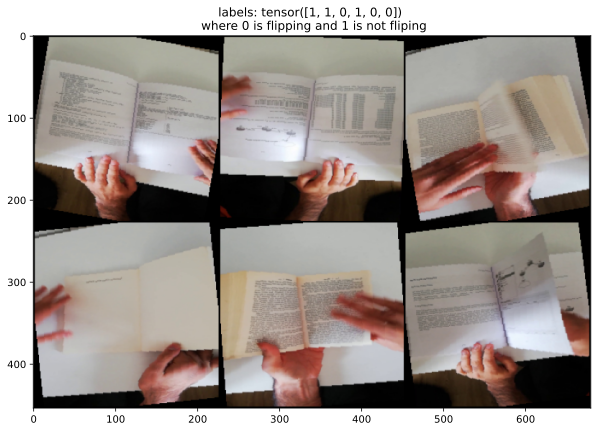

In [13]:
show_transformed_images(train_dataset)

In [14]:
#getting the dataloaders
train_loader = get_data_loader(train_dataset)
val_loader = get_data_loader(val_dataset, shuffle=False)
test_loader = get_data_loader(test_dataset, shuffle=False)

In [15]:
inputs, classes = next(iter(train_loader))

print(f'Batch size: {inputs.shape[0]}')
print(f'Number of color channels: {inputs.shape[1]}')
print(f'Image size: {inputs.shape[2]} x {inputs.shape[3]}')
print(f'Labels of the first batch: {classes}')

Batch size: 16
Number of color channels: 3
Image size: 224 x 224
Labels of the first batch: tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1])


# Checking device and setting deterministic options

In [16]:
print("Using torch", torch.__version__)

Using torch 2.1.0


In [17]:
torch.manual_seed(42)  # Setting the seed

In [18]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [19]:
# Check device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [20]:
if torch.cuda.is_available(): # GPU operations have a separate seed we also want to set
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Creating a model

In [36]:
#convolutional neural network

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
            
        )
    
    def forward(self, x):
        out = torch.sigmoid(self.main(x)) ## sigmoid as we will use the binary cross entropy loss
        return out

In [26]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            ## block 1
            nn.Conv2d(in_channels=3, out_channels=64,
                      kernel_size=(3, 3)),  ## Convo layer

            nn.ReLU(),                      ## ReLU activation function
            nn.MaxPool2d((2, 2)),           ## Pooling layer
            nn.Dropout(p=.1),               ## Dropout layer

            ## block 2
            nn.Conv2d(64, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(p=.1),
            
            ## block 3
            nn.Conv2d(32, 16, (2,2)),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(p=.1),
             
            nn.Flatten(),
            nn.Linear(10816, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,1))

    def forward(self, x):
        out = torch.sigmoid(self.main(x)) ## sigmoid as we will use the BCELoss loss function
        return out

In [30]:
cnn_model = Net()
summary(cnn_model, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 111, 111]        --
|    └─Dropout: 2-4                      [-1, 64, 111, 111]        --
|    └─Conv2d: 2-5                       [-1, 32, 109, 109]        18,464
|    └─ReLU: 2-6                         [-1, 32, 109, 109]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 54, 54]          --
|    └─Dropout: 2-8                      [-1, 32, 54, 54]          --
|    └─Conv2d: 2-9                       [-1, 16, 53, 53]          2,064
|    └─ReLU: 2-10                        [-1, 16, 53, 53]          --
|    └─MaxPool2d: 2-11                   [-1, 16, 26, 26]          --
|    └─Dropout: 2-12                     [-1, 16, 26, 26]          --
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 111, 111]        --
|    └─Dropout: 2-4                      [-1, 64, 111, 111]        --
|    └─Conv2d: 2-5                       [-1, 32, 109, 109]        18,464
|    └─ReLU: 2-6                         [-1, 32, 109, 109]        --
|    └─MaxPool2d: 2-7                    [-1, 32, 54, 54]          --
|    └─Dropout: 2-8                      [-1, 32, 54, 54]          --
|    └─Conv2d: 2-9                       [-1, 16, 53, 53]          2,064
|    └─ReLU: 2-10                        [-1, 16, 53, 53]          --
|    └─MaxPool2d: 2-11                   [-1, 16, 26, 26]          --
|    └─Dropout: 2-12                     [-1, 16, 26, 26]          --
|    

In [37]:
cnn_model = ConvNet()
batch_size = 16
summary(cnn_model, input_size=(3, 224, 224), batch_size=batch_size, device=device)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       448
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       4,640
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       18,496
|    └─ReLU: 2-8                         --
|    └─MaxPool2d: 2-9                    --
|    └─Flatten: 2-10                     --
|    └─Linear: 2-11                      3,211,328
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      65
Total params: 3,234,977
Trainable params: 3,234,977
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       448
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       4,640
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       18,496
|    └─ReLU: 2-8                         --
|    └─MaxPool2d: 2-9                    --
|    └─Flatten: 2-10                     --
|    └─Linear: 2-11                      3,211,328
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      65
Total params: 3,234,977
Trainable params: 3,234,977
Non-trainable params: 0